# 0 Imports

In [1]:
import os, warnings, re, shutil
from datetime import datetime
from ast import literal_eval

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import multilabel_confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, hamming_loss, precision_score, recall_score, f1_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from skmultilearn.model_selection import iterative_train_test_split

from bs4 import BeautifulSoup as bs
import nltk
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import SnowballStemmer, WordNetLemmatizer
# nltk.download()
from wordcloud import WordCloud

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
from tensorflow.python.profiler import trace
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
from tensorflow import keras
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, AveragePooling1D, Flatten
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy, AUC
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import bert
from transformers import TFBertModel, BertConfig, BertTokenizerFast, DistilBertTokenizerFast, DistilBertConfig, TFDistilBertModel
from tokenizers import BertWordPieceTokenizer

# tf.compat.v1.disable_eager_execution()
tf.compat.v1.enable_eager_execution()

import scripts

def set_seed(seed=31415):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()

plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=18, titlepad=10)
plt.rc('image', cmap='magma')
warnings.filterwarnings("ignore")

print("-----------------------------------------")
if tf.test.gpu_device_name():
    print(f"GPU used: {tf.test.gpu_device_name()}")
else:
    print(f"GPU not used")
print("-----------------------------------------")

from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

/home/alex/anaconda3/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


-----------------------------------------
GPU used: /device:GPU:0
-----------------------------------------
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9012997526954523710
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3460038656
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8985313046292101113
physical_device_desc: "device: 0, name: Quadro P2000, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


2022-02-20 12:18:46.428685: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-20 12:18:46.444173: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-20 12:18:46.475638: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-20 12:18:46.475829: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

***
# 1 Config

In [2]:
config = {
    "raw_preprocessing": False,
    "preprocessing": False,
    "baseline": False,
    "bert_base": False,
    "bert_se": False,
    "bert_distil": True
}

***
# 2 Preprocessing

## 2.0 Utils

In [3]:
def preproc_raw_data_body(cell):
    soup = bs(cell, "html.parser")

    script_tags = soup.find_all("script")
    for script_tag in script_tags:
        script_tag.extract()

    code_tags = soup.find_all("code")
    for code_tag in code_tags:
        code_tag.extract()

    preproc_cell = soup.get_text()
    preproc_cell = preproc_cell.replace(',', ' ')

    return preproc_cell

In [4]:
def tags_to_list(cell):
    return [tag for tag in re.split(r'[<>]', cell) if tag]

In [5]:
def lower(cell):
    return cell.lower()

In [6]:
def tokenize(*texts):
    tokens = []
    for text in texts:
        # https://regex101.com/
        tokenizer = nltk.RegexpTokenizer(r'\.?[a-z#]+')
        tokens_temp = tokenizer.tokenize(text)
        tokens += [re.sub("(.)\\1{3,}", "\\1", token) for token in tokens_temp]
    return tokens

In [7]:
def remove_stop_words(cell):
    return [word for word in cell if word not in stop_words]

In [8]:
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return 'n'

In [9]:
def tag_pos(cell):
    treebank_tags = pos_tag(cell)
    pos = [(tag[0], get_wordnet_pos(tag[1])) for tag in treebank_tags]
    return pos

In [10]:
def lemmatize(cell, with_pos=False):
    lemmatizer = WordNetLemmatizer()
    if not with_pos:
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in cell]
    else:
        lemmatized_tokens = [lemmatizer.lemmatize(pair[0], pos=pair[1]) for pair in cell]
    return lemmatized_tokens

In [11]:
def stemmize(cell):
    stemmer = SnowballStemmer("english")
    stemmed_tokens = [stemmer.stem(token) for token in cell]
    return stemmed_tokens

## 2.1 Loading raw data

In [12]:
if config["raw_preprocessing"]:

    raw_data_body = pd.read_csv("data/raw_data_body.csv")
    raw_data_body.shape

## 2.2 Parse html

In [13]:
if config["raw_preprocessing"]:

    raw_data_body["Body"] = raw_data_body.apply(lambda row: preproc_raw_data_body(row.Body), axis=1)

## 2.3 Merge body with rest

In [14]:
display = None

if config["raw_preprocessing"]:

    raw_data_rest = pd.read_csv("data/raw_data_id_title_tags.csv")
    raw_data = raw_data_rest.join(raw_data_body)
    raw_data = raw_data.set_index("Id").reindex(["Title", "Body", "Tags"], axis="columns")
    raw_data["Sentence_Pristine"] = raw_data.apply(lambda row: row["Title"] + " " + row["Body"], axis="columns")
    display = raw_data.head()

display

## 2.4 Tags to list

In [15]:
display = None

if config["raw_preprocessing"]:

    raw_data["Tags"] = raw_data.apply(lambda row: tags_to_list(row["Tags"]), axis="columns")
    display = raw_data[["Tags"]].head()

display

## 2.5 Lowering

In [16]:
display = None

if config["raw_preprocessing"]:

    raw_data["Sentence_Pristine"] = raw_data.apply(lambda row: lower(row["Sentence_Pristine"]), axis="columns")
    display = raw_data[["Sentence_Pristine"]].head()

display

## 2.6 Save raw preprocessed data

In [17]:
if config["raw_preprocessing"]:
    
    raw_data.drop(columns=["Title", "Body"], inplace=True)
    raw_data.to_csv("data/raw_data.csv")

## 2.7 Load raw preprocessed data

In [18]:
if config["preprocessing"]:
    
    data = pd.read_csv("data/raw_data.csv", index_col="Id")

## 2.8 Tokenize

In [19]:
display = None

if config["preprocessing"]:

    data["Tokens"] = data.apply(lambda row: tokenize(row["Sentence_Pristine"]), axis="columns")
    display = data[["Sentence_Pristine", "Tokens"]].head()

display

## 2.9 StopWords deletion

In [20]:
display = None

if config["preprocessing"]:

    stop_words = stopwords.words("english")
    data["Tokens"] = data.apply(lambda row: remove_stop_words(row["Tokens"]), axis="columns")
    display = data[["Sentence_Pristine", "Tokens"]].head()

display

## 2.10 POS - Part-Of-Speech

In [21]:
display = None

if config["preprocessing"]:

    data["POS"] = data.apply(lambda row: tag_pos(row["Tokens"]), axis="columns")
    display = data[["Tokens", "POS"]].head()

display

## 2.11 Lemmatize

In [22]:
display = None

if config["preprocessing"]:

    data["Lemmatized"] = data.apply(lambda row: lemmatize(row["POS"], with_pos=True), axis="columns")
    display = data[["Tokens", "Lemmatized"]].head()

display

## 2.12 Stemmize

In [23]:
display = None

if config["preprocessing"]:

    data["LemmaAndStem"] = data.apply(lambda row: stemmize(row["Tokens"]), axis="columns")
    display = data[["Tokens", "LemmaAndStem"]].head()

display

## 2.13 Generating sentence

In [24]:
display = None

if config["preprocessing"]:

    data["Sentence"] = data.apply(lambda row: " ".join([str(item) for item in row["LemmaAndStem"]]), axis="columns")
    display = data[["LemmaAndStem", "Sentence"]].head()

display

## 2.14 Saving data

In [25]:
display = None

if config["preprocessing"]:

    data.to_csv("data/data_cleaned.csv", index_label="Id")
    display = data.head()

display

***
# 3 Data preparation

## 3.0 Utils

In [26]:
def bow(dataset, max_features=None, min_df=0.0, max_df=1.0):
    vectorizer = CountVectorizer(analyzer="word", tokenizer=None, preprocessor=None, stop_words=None, max_features=max_features, max_df=max_df, min_df=min_df)
    matrix = vectorizer.fit_transform(dataset)

    data_dense = matrix.todense()
    print(f"Sparcity: {((data_dense > 0).sum() / data_dense.size)*100:.4}%")

    vocab = vectorizer.get_feature_names_out()

    matrix = matrix.toarray()
    bag = pd.DataFrame(data=matrix, columns=vocab)
    return bag, vectorizer

In [27]:
def tfidf(dataset, max_features=None, min_df=0.0, max_df=1.0):
    vectorizer = TfidfVectorizer(tokenizer=None, stop_words=None, max_features=max_features, min_df=min_df, max_df=max_df)
    matrix = vectorizer.fit_transform(dataset).toarray()
    vocab = vectorizer.get_feature_names_out()
    tfidf = pd.DataFrame(data=matrix, columns=vocab)
    return tfidf, vectorizer

## 3.1 Loading

In [28]:
data = pd.read_csv("data/data_cleaned.csv", index_col="Id")
data = data.reset_index()
data = data.iloc[:, 1:]

data["Tags"] = data["Tags"].apply(eval)

data.head()

,Tags,Sentence_Pristine,Tokens,POS,Lemmatized,LemmaAndStem,Sentence
0,"[c#, floating-point, type-conversion, double, ...",how to convert a decimal to a double in c#? i ...,"['convert', 'decimal', 'double', 'c#', 'want',...","[('convert', 'n'), ('decimal', 'n'), ('double'...","['convert', 'decimal', 'double', 'c#', 'want',...","['convert', 'decim', 'doubl', 'c#', 'want', 'u...",convert decim doubl c# want use chang opac cod...
1,"[html, css, internet-explorer-7]",why did the width collapse in the percentage w...,"['width', 'collapse', 'percentage', 'width', '...","[('width', 'n'), ('collapse', 'n'), ('percenta...","['width', 'collapse', 'percentage', 'width', '...","['width', 'collaps', 'percentag', 'width', 'ch...",width collaps percentag width child element ab...
2,"[c#, .net, datetime]",how do i calculate someone's age based on a da...,"['calculate', 'someone', 'age', 'based', 'date...","[('calculate', 'n'), ('someone', 'n'), ('age',...","['calculate', 'someone', 'age', 'base', 'datet...","['calcul', 'someon', 'age', 'base', 'datetim',...",calcul someon age base datetim type birthday g...
3,"[c#, datetime, time, datediff, relative-time-s...",calculate relative time in c# given a specific...,"['calculate', 'relative', 'time', 'c#', 'given...","[('calculate', 'v'), ('relative', 'a'), ('time...","['calculate', 'relative', 'time', 'c#', 'give'...","['calcul', 'relat', 'time', 'c#', 'given', 'sp...",calcul relat time c# given specif valu display...
4,"[html, browser, timezone, user-agent, timezone...",determine a user's timezone is there a standar...,"['determine', 'user', 'timezone', 'standard', ...","[('determine', 'v'), ('user', 'n'), ('timezone...","['determine', 'user', 'timezone', 'standard', ...","['determin', 'user', 'timezon', 'standard', 'w...",determin user timezon standard way web server ...


In [29]:
data = data[["Sentence_Pristine", "Sentence", "Tags"]]
data.head()

,Sentence_Pristine,Sentence,Tags
0,how to convert a decimal to a double in c#? i ...,convert decim doubl c# want use chang opac cod...,"[c#, floating-point, type-conversion, double, ..."
1,why did the width collapse in the percentage w...,width collaps percentag width child element ab...,"[html, css, internet-explorer-7]"
2,how do i calculate someone's age based on a da...,calcul someon age base datetim type birthday g...,"[c#, .net, datetime]"
3,calculate relative time in c# given a specific...,calcul relat time c# given specif valu display...,"[c#, datetime, time, datediff, relative-time-s..."
4,determine a user's timezone is there a standar...,determin user timezon standard way web server ...,"[html, browser, timezone, user-agent, timezone..."


In [30]:
data.shape

(50000, 3)

***
## 3.2 Dataset constraints

BERT_SE fine_tuning has been done for a dataset of 23 313 rows, then our 50k rows dataset must be constraint

In [31]:
data = data.iloc[:23313]

In [32]:
data.shape

(23313, 3)

In [33]:
data.head()

,Sentence_Pristine,Sentence,Tags
0,how to convert a decimal to a double in c#? i ...,convert decim doubl c# want use chang opac cod...,"[c#, floating-point, type-conversion, double, ..."
1,why did the width collapse in the percentage w...,width collaps percentag width child element ab...,"[html, css, internet-explorer-7]"
2,how do i calculate someone's age based on a da...,calcul someon age base datetim type birthday g...,"[c#, .net, datetime]"
3,calculate relative time in c# given a specific...,calcul relat time c# given specif valu display...,"[c#, datetime, time, datediff, relative-time-s..."
4,determine a user's timezone is there a standar...,determin user timezon standard way web server ...,"[html, browser, timezone, user-agent, timezone..."


***
## 3.3 Tags

In [34]:
data[["Tags"]].head()

,Tags
0,"[c#, floating-point, type-conversion, double, ..."
1,"[html, css, internet-explorer-7]"
2,"[c#, .net, datetime]"
3,"[c#, datetime, time, datediff, relative-time-s..."
4,"[html, browser, timezone, user-agent, timezone..."


In [35]:
data.Tags.values

array([list(['c#', 'floating-point', 'type-conversion', 'double', 'decimal']),
       list(['html', 'css', 'internet-explorer-7']),
       list(['c#', '.net', 'datetime']), ...,
       list(['asp.net', 'concurrency', 'lucene', 'lucene.net']),
       list(['java', 'c', 'floating-point']), list(['ajax', 'loader'])],
      dtype=object)

In [36]:
tags = []
for row in data.Tags.values:
    tags += row
tags_df = pd.DataFrame(data=tags, columns=["Tag"]).value_counts().reset_index()
tags_df.columns = ["Tag", "Count"]

In [37]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6271 entries, 0 to 6270
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tag     6271 non-null   object
 1   Count   6271 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 98.1+ KB


In [38]:
tags_df.head()

,Tag,Count
0,c#,2865
1,.net,2566
2,java,1764
3,asp.net,1399
4,c++,1206


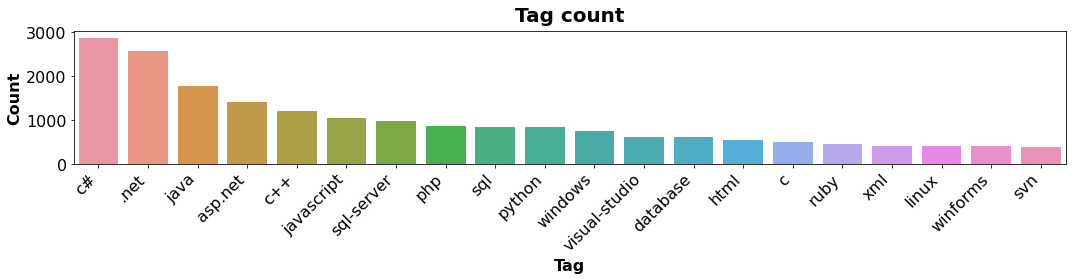

In [39]:
plt.figure(figsize=(15, 4))

sns.barplot(data=tags_df.iloc[:20], x="Tag", y="Count")

plt.title("Tag count", size=20)
plt.xlabel("Tag", size=16)
plt.ylabel("Count", size=16)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.show()

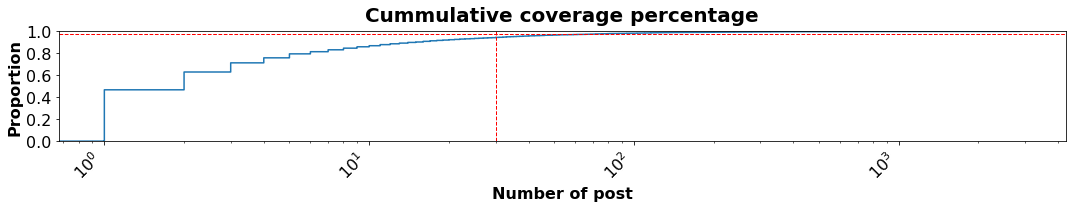

In [40]:
plt.figure(figsize=(15, 3))

ax = sns.ecdfplot(data=tags_df, x="Count", log_scale=True)

plt.axhline(0.98, linestyle="--", linewidth=1, color="r")
plt.axvline(30, linestyle="--", linewidth=1, color="r")

plt.title("Cummulative coverage percentage", size=20)
plt.xlabel("Number of post", size=16)
plt.ylabel("Proportion", size=16)
plt.xticks(rotation=45, size=16, ha="right")
plt.yticks(size=16)
plt.show()

In [41]:
tags_df = tags_df[:30]
TAGS_NB = tags_df.shape[0]
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Tag     30 non-null     object
 1   Count   30 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 608.0+ bytes


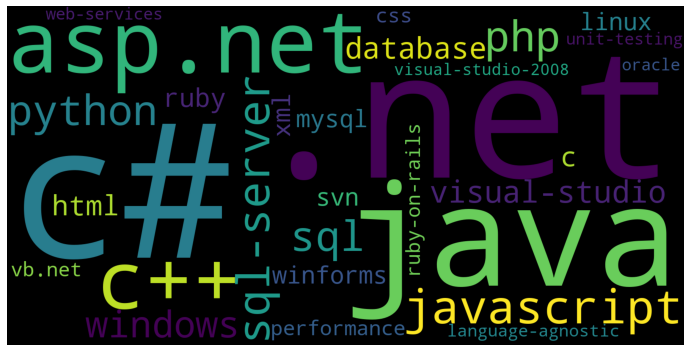

In [42]:
word_frequencies = dict(zip(tags_df.Tag, tags_df.Count))
wordcloud = WordCloud(background_color="black", width=1600, height=800).generate_from_frequencies(word_frequencies)

fig = plt.figure(figsize=(15, 5))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [43]:
tags = tags_df.Tag.tolist()

In [44]:
tags[:20]

['c#',
 '.net',
 'java',
 'asp.net',
 'c++',
 'javascript',
 'sql-server',
 'php',
 'sql',
 'python',
 'windows',
 'visual-studio',
 'database',
 'html',
 'c',
 'ruby',
 'xml',
 'linux',
 'winforms',
 'svn']

In [45]:
def find_or_remove(cell, word_list):
    return [word for word in cell if word in word_list]

In [46]:
data["Tags_Reduced"] = data.apply(lambda row: find_or_remove(row["Tags"], tags),axis="columns")

In [47]:
data["Tags_Reduced"].isna().any()

False

In [48]:
data["Tags_Reduced"].head()

0           [c#]
1    [html, css]
2     [c#, .net]
3           [c#]
4         [html]
Name: Tags_Reduced, dtype: object

In [49]:
# data["Tags_Reduced"] = data.apply(lambda row: at_least_two(row), axis=1)
# data.dropna(subset=["Tags_Reduced"], inplace=True)
# data.shape

***
# 4 Baseline

## 4.0 Utils

In [50]:
# https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/#9buildldamodelwithsklearn
#
def latent_dirichlet_allocation_tuning(dataset: pd.DataFrame, param_grid: dict):
    data_bow, vectorizer = bow(dataset, min_df=.005)
    feature_names = data_bow.columns

    lda = LatentDirichletAllocation()
    gs = GridSearchCV(lda, param_grid)
    gs.fit(data_bow)

    lda_model = gs.best_estimator_
    lda_output = lda_model.transform(data_bow)
    topic_names = ["Topic"+str(i) for i in range(lda_model.n_components)]

    lda_output_dataframe = pd.DataFrame(np.round(lda_output, 2), columns=topic_names)

    return gs, feature_names, data_bow, vectorizer, lda_output_dataframe

In [51]:
def get_dominant_topic(lda_model, data_bow, dataset_row_nb):
    lda_output = lda_model.transform(data_bow)

    topic_names = ["Topic"+str(i) for i in range(lda_model.n_components)]
    doc_names = ["Doc"+str(i) for i in range(dataset_row_nb)]

    df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topic_names, index=doc_names)

    dominant_topics = np.argmax(df_document_topic.values, axis=1)
    df_document_topic["Dominant_Topic"] = dominant_topics

    return df_document_topic

In [52]:
def topic_distribution(dominant_topic_df):
    distribution = dominant_topic_df["Dominant_Topic"].value_counts().reset_index()
    distribution.columns = ["Dominant_Topic", "Count"]

    plt.figure(figsize=(15, 4))

    sns.countplot(data=dominant_topic_df, x="Dominant_Topic")

    plt.title("Tag count", size=20)
    plt.xlabel("Tag", size=16)
    plt.ylabel("Count", size=16)
    plt.xticks(rotation=45, size=16, ha="right")
    plt.yticks(size=16)
    plt.show()

    return distribution

In [53]:
def topic_words(lda_model, feature_names, n_words=20):
    keywords = np.array(feature_names)
    topic_keywords = []
    for topic_weight in lda_model.components_:
        topic_keyword_locs = (-topic_weight).argsort()[:n_words]
        topic_keywords.append(feature_names.take(topic_keyword_locs))
    
    topic_keywords_df = pd.DataFrame(data=topic_keywords)
    topic_keywords_df.columns = ["Word"+str(i) for i in range(topic_keywords_df.shape[1])]
    topic_keywords_df.index = ["Topic"+str(i) for i in range(topic_keywords_df.shape[0])]
    return topic_keywords_df

In [54]:
def make_prediction(lda_model, sentence, vectorizer, topic_keywords_dataset):
    sentence = scripts.preprocess_sentence(sentence)
    data_bow = vectorizer.transform([sentence])
    topic_probability_score = lda_model.transform(data_bow)
    topic = topic_keywords_dataset.iloc[np.argmax(topic_probability_score), :]
    topic_name = topic.name
    topic_words = topic.values.tolist()
    return topic_name, topic_words, topic_probability_score

In [55]:
def classifier_tuning_post_lda(dataset_X: pd.DataFrame, dataset_y: pd.DataFrame, meta_model, model, param_grid: dict, scoring: str = "f1_micro"):
    start = datetime.now()

    # target multi label binarizer
    multi_label_binarizer = MultiLabelBinarizer()
    y = multi_label_binarizer.fit_transform(dataset_y)

    feature_names = dataset_X.columns
    classes = multi_label_binarizer.classes_

    X_train, X_test, y_train, y_test = train_test_split(dataset_X, y, test_size = 0.33, random_state = 1)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # multioutput or onevsrest ...
    meta_model.fit(X_train, y_train)

    # gridsearch tuning/fitting
    gs = GridSearchCV(meta_model, param_grid, scoring=scoring, refit=True)
    gs.fit(X_train, y_train)

    # advanced evaluation
    best_model = gs.best_estimator_
    y_pred = best_model.predict(X_test)

    print(f"classifier_tuning > Time taken to run this cell : {datetime.now() - start} \n")

    return gs, classes, y_test, y_pred

In [56]:
def evaluate(gs, classes, y_test, y_pred):
    start = datetime.now()

    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Hamming loss ", hamming_loss(y_test, y_pred))

    precision = precision_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    f1 = f1_score(y_test, y_pred, average='micro')
    
    print("Micro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    print("Macro-average quality numbers")
    print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

    print(classification_report(y_test, y_pred, target_names=classes, zero_division=0))

    print(f"evaluate > Time taken to run this cell : {datetime.now() - start}\n")

***
## 4.1 Latent Dirichlet Allocation

In [57]:
if config["baseline"]:

    param_grid = {
        "n_components": [10],
        "learning_decay": [.7],
        "random_state": [0],
        "n_jobs": [10]
    }

    gs, feature_names, data_bow, vectorizer, lda_output_dataframe = latent_dirichlet_allocation_tuning(data["Sentence"], param_grid)

In [58]:
if config["baseline"]:

    print(f"Log likelihood: {gs.best_estimator_.score(data_bow)}")
    print(f"Perplexity: {gs.best_estimator_.perplexity(data_bow)}")
    print(f"Best params: {gs.best_params_}")

In [59]:
if config["baseline"]:

    dominant_topic_df = get_dominant_topic(gs.best_estimator_, data_bow, data.shape[0])
    dominant_topic_df.head()

In [60]:
if config["baseline"]:

    topic_distribution(dominant_topic_df)

In [61]:
if config["baseline"]:

    topic_keywords_df = pd.DataFrame(data=gs.best_estimator_.components_, columns=feature_names, index=dominant_topic_df.columns[:-1])
    topic_keywords_df.info()    

In [62]:
display = None

if config["baseline"]:

    display = topic_keywords_df.iloc[:, :20]

display

In [63]:
display = None

if config["baseline"]:

    topic_keywords_dataset = topic_words(lda_model=gs.best_estimator_, feature_names=feature_names, n_words=20)
    display = topic_keywords_dataset

display

In [64]:
if config["baseline"]:

    param_grid = {
        "estimator__solver": ["liblinear"],
        "estimator__penalty": ["l1"],
        "estimator__random_state": [0],
    }

    model = LogisticRegression()
    meta_model = OneVsRestClassifier(model)
    gs, classes, y_test, y_pred = classifier_tuning_post_lda(lda_output_dataframe, data["Tags_Reduced"], meta_model, model, param_grid)
    evaluate(gs, classes, y_test, y_pred)

***
## 4.2 Results

<img src="records/lda_results_metrics.png" style="background-color:white">

<img src="records/lda_results_topic_distrib_plot.png" style="background-color:white">

<img src="records/lda_results_topic_words.png" style="background-color:white">

<img src="records/logistic_classifier_results_01.png" style="background-color:white">

<img src="records/logistic_classifier_results_02.png" style="background-color:white">

<img src="records/logistic_classifier_results_03.png" style="background-color:white">

***
# 5 NN preparation

## 5.0 Utils

In [65]:
def make_pseudo_list(row):
    ls = row["Tags_Reduced"]
    cell = "["
    for elt in ls:
        cell = cell + "'" + elt + "',"
    cell = cell + "]"
    return cell

In [66]:
def at_least_two(row):
    tags_list = row["Tags_Reduced"]
    tags_list_len = len(tags_list)
    if tags_list_len > 1:
        return row["Tags_Reduced"]

In [67]:
# about multilabelbinarizer, reverse action
def to_class(mlb, vec):
    indexes = [i for i in range(len(vec)) if vec[i] != 0]
    return ' '.join([list(mlb.classes_)[i] for i in indexes])

In [68]:
def multi_label_accuracy(y_true: tf.Tensor, y_pred: tf.Tensor) -> tf.Tensor:
    """For multi-label classification, one has to define a custom
    acccuracy function because neither tf.keras.metrics.Accuracy nor
    tf.keras.metrics.CategoricalAccuracy evaluate the number of 
    exact matches.

    :Example:
    >>> from tensorflow.keras import metrics
    >>> y_true = tf.convert_to_tensor([[1., 1.]])
    >>> y_pred = tf.convert_to_tensor([[1., 0.]])
    >>> metrics.Accuracy()(y_true, y_pred).numpy()
    0.5
    >>> metrics.CategoricalAccuracy()(y_true, y_pred).numpy()
    1.0
    >>> multi_label_accuracy(y_true, y_pred).numpy()
    0.0
    """   
    y_pred = tf.math.round(y_pred)
    exact_matches = tf.math.reduce_all(y_pred == y_true, axis=1)
    exact_matches = tf.cast(exact_matches, tf.float32)
    return tf.math.reduce_mean(exact_matches)

In [69]:
def hamming_loss(y_true, y_pred):
    return K.mean(y_true*(1-y_pred)+(1-y_true)*y_pred)

In [70]:
def Custom_Hamming_Loss1(y_true, y_pred):
    tmp = K.abs(y_true-y_pred)
    return K.mean(K.cast(K.greater(tmp,0.5),dtype=float))

In [71]:
def f1_metric(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [72]:
def jaccard_distance(y_true, y_pred, smooth=100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

In [73]:
def visualize_history(history, figsize=(20, 10), metrics: str = "categorical_accuracy"):
    fix, axs = plt.subplots(2, 1, figsize=figsize, sharex=True)

    plt.subplot(2, 1, 1)
    plt.title("Loss")
    sns.lineplot(data=history, x=history.index, y="loss", label="loss")
    sns.lineplot(data=history, x=history.index, y="val_loss", label="val_loss")
    plt.xlabel("epochs")
    plt.tick_params(labelright=True)
    plt.legend()
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.title("Accuracy")
    sns.lineplot(data=history, x=history.index, y=metrics, label=metrics)
    sns.lineplot(data=history, x=history.index, y="val_" + metrics, label="val_" + metrics)
    plt.xlabel("epochs")
    plt.tick_params(labelright=True)
    plt.legend()
    plt.grid()

***
## 5.1 Data split

In [74]:
tags = data[["Tags_Reduced"]]
tags.head()

,Tags_Reduced
0,[c#]
1,"[html, css]"
2,"[c#, .net]"
3,[c#]
4,[html]


In [75]:
X = data[["Sentence_Pristine"]]

In [76]:
binarizer = MultiLabelBinarizer()
y_binarized = binarizer.fit_transform(data["Tags_Reduced"])
y_binarized_df = pd.DataFrame(y_binarized, columns=binarizer.classes_, index=data.index)
data = X.join(y_binarized_df)
data.head()

,Sentence_Pristine,.net,asp.net,c,c#,c++,css,database,html,java,...,sql-server,svn,unit-testing,vb.net,visual-studio,visual-studio-2008,web-services,windows,winforms,xml
0,how to convert a decimal to a double in c#? i ...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,why did the width collapse in the percentage w...,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,how do i calculate someone's age based on a da...,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,calculate relative time in c# given a specific...,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,determine a user's timezone is there a standar...,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
y = data.iloc[:, 1:]
y.head()

,.net,asp.net,c,c#,c++,css,database,html,java,javascript,...,sql-server,svn,unit-testing,vb.net,visual-studio,visual-studio-2008,web-services,windows,winforms,xml
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [78]:
X = X["Sentence_Pristine"]
X.head()

0    how to convert a decimal to a double in c#? i ...
1    why did the width collapse in the percentage w...
2    how do i calculate someone's age based on a da...
3    calculate relative time in c# given a specific...
4    determine a user's timezone is there a standar...
Name: Sentence_Pristine, dtype: object

In [79]:
data["Sentence_Pristine"].head()

0    how to convert a decimal to a double in c#? i ...
1    why did the width collapse in the percentage w...
2    how do i calculate someone's age based on a da...
3    calculate relative time in c# given a specific...
4    determine a user's timezone is there a standar...
Name: Sentence_Pristine, dtype: object

In [80]:
X_train_, X_test_, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

Text(0.5, 1.0, 'Texts length distribution (number of words):')

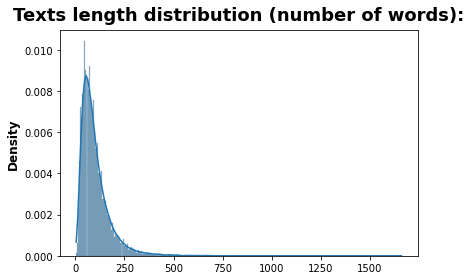

In [81]:
text_lenghts = [len(t.split()) for t in X]
ax = sns.histplot(data=text_lenghts, kde=True, stat="density")
ax.set_title("Texts length distribution (number of words):")

In [82]:
max_length = 100

***
# 6 BERT_base

## 6.1 Loading BERT

In [83]:
if config["bert_base"]:

    model_name = "bert-base-uncased"

In [84]:
if config["bert_base"]:
    
    bert_config = BertConfig.from_pretrained(model_name)
    bert_config.output_hidden_states = False

In [85]:
if config["bert_base"]:

    tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path=model_name, config=bert_config)

***
## 6.2 BERT Tokenizer

In [86]:
if config["bert_base"]:
    
    X_train = tokenizer(
        text=X_train_.to_list(),
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=True,
        return_attention_mask=True,
        verbose=True
    )

    X_test = tokenizer(
        text=X_test_.to_list(),
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding=True, 
        return_tensors='tf',
        return_token_type_ids = True,
        return_attention_mask = True,
        verbose = True
    )

In [87]:
if config["bert_base"]:

    X_train.keys()

In [88]:
if config["bert_base"]:

    X_train["input_ids"][0]

In [89]:
if config["bert_base"]:

    X_train["token_type_ids"][0]

In [90]:
if config["bert_base"]:

    X_train["attention_mask"][0]

***
## 6.3 Tensorflow dataset creation

In [91]:
if config["bert_base"]:
    
    ds_train = tf.data.Dataset.from_tensor_slices((dict(X_train), y_train))
    ds_test = tf.data.Dataset.from_tensor_slices((dict(X_test), y_test))

***
## 6.4 Network

In [92]:
if config["bert_base"]:

    bert_model_name = "bert-base-uncased"
    max_seq_len = 100
    tags_nb = TAGS_NB

In [93]:
if config["bert_base"]:

    input_ids = keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name='input_ids')
    input_type = keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name='token_type_ids')
    input_mask = keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name='attention_mask')
    inputs = [input_ids, input_type, input_mask]

    bert = TFBertModel.from_pretrained(bert_model_name)
    bert_outputs = bert(inputs)
    last_hidden_states = bert_outputs.last_hidden_state

    avg = keras.layers.GlobalAveragePooling1D()(last_hidden_states)
    output = keras.layers.Dense(tags_nb, activation="sigmoid")(avg)

    model = keras.Model(inputs=inputs, outputs=output)

    model.summary()

In [94]:
if config["bert_base"]:

    max_epochs = 4
    batch_size = 4

    opt = tfa.optimizers.RectifiedAdam(learning_rate=3e-5)
    loss = keras.losses.BinaryCrossentropy()
    best_weights_file = "bert_base_weights.h5"

    m_ckpt = ModelCheckpoint(
        best_weights_file,
        monitor='val_auc_1',
        mode='max',
        verbose=2,
        save_weights_only=True,
        save_best_only=True
    )

    model.compile(
        loss=loss,
        optimizer=opt,
        metrics=[
            keras.metrics.AUC(multi_label=True, curve="ROC"),
            keras.metrics.BinaryAccuracy()
        ]
    )

    history = model.fit(
        ds_train.shuffle(1000).batch(batch_size),
        validation_data=ds_test.batch(batch_size),
        epochs=max_epochs,
        batch_size=batch_size,
        callbacks=[m_ckpt],
    )

***
## 6.5 Results

In [95]:
if config["bert_base"]:

    history_bert = pd.DataFrame(data=history.history)
    for metric in ["auc_1", "binary_accuracy"]:
        visualize_history(history_bert, metrics=metric)

***
### 6.5.1 History

<img src="records/bert_base_results_auc.png" style="background-color:white">

<img src="records/bert_base_results_binaccuracy.png" style="background-color:white">

***
# 7 BERT_SE

## 7.1 Loading BERT_SE

In [96]:
if config["bert_se"]:

    pret_model = pd.read_csv('data/bert_se/BERT_SE.csv', delimiter= ',', header=None)
    MAX_LEN = data.shape[0]
    print(f"MAX_LEN: {MAX_LEN}")

In [97]:
if config["bert_se"]:

    embedding_matrix = pret_model.iloc[0:MAX_LEN,:]
    dfEmbedding_mat = pd.DataFrame(embedding_matrix)
    embedding_mat = dfEmbedding_mat.fillna('0')

***
## 7.2 BERT_SE Tokenizer

In [98]:
if config["bert_se"]:

    model_name = "bert-base-uncased"
    bert_config = BertConfig.from_pretrained(model_name)
    bert_config.output_hidden_states = False
    tokenizer = BertTokenizerFast.from_pretrained(pretrained_model_name_or_path=model_name, config=bert_config)

In [99]:
if config["bert_se"]:

    X_train = tokenizer(
        text=X_train_.to_list(),
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=True,
        return_attention_mask=True,
        verbose=True
    )

    X_test = tokenizer(
        text=X_test_.to_list(),
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding=True, 
        return_tensors='tf',
        return_token_type_ids = True,
        return_attention_mask = True,
        verbose = True
    )

In [100]:
display = None 

if config["bert_se"]:

    display = X_train.keys()

display

In [101]:
display = None

if config["bert_se"]:

    display = X_train["input_ids"][0]

display

In [102]:
display = None

if config["bert_se"]:

    display = X_train["token_type_ids"][0]

display

In [103]:
display = None

if config["bert_se"]:

    display = X_train["attention_mask"][0]

display

***
## 7.3 Tensorflow dataset creation

In [104]:
if config["bert_se"]:

    ds_train = tf.data.Dataset.from_tensor_slices((dict(X_train), y_train))
    ds_test = tf.data.Dataset.from_tensor_slices((dict(X_test), y_test))

***
## 7.4 Network

In [105]:
if config["bert_se"]:

    bert_model_name = "bert-base-uncased"
    max_seq_len = 100
    tags_nb = TAGS_NB

In [106]:
if config["bert_se"]:

    input_ids = keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name='input_ids')
    input_type = keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name='token_type_ids')
    input_mask = keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name='attention_mask')
    inputs = [input_ids, input_type, input_mask]

    bert = Embedding(MAX_LEN, 768, input_length = 100, name='embedding', trainable=False, weights=[embedding_mat])
    # bert.build(input_shape=(1,))
    # bert.set_weights([embedding_mat])
    bert_outputs = bert(input_ids)

    avg = keras.layers.GlobalAveragePooling1D()(bert_outputs)

    output = keras.layers.Dense(tags_nb, activation="sigmoid")(avg)
    model = keras.Model(inputs=inputs, outputs=output)

    model.summary()

In [107]:
if config["bert_se"]:

    max_epochs = 20
    batch_size = 32

    opt = tfa.optimizers.RectifiedAdam(learning_rate=3e-5)
    # opt = Adam(lr = 0.001, beta_1 = 0.99, beta_2 = 0.999, epsilon = None, decay = 0.01, amsgrad = False)
    # opt = Adam(lr=1e-4, beta_1 = 0.9, beta_2 = 0.999, epsilon = None, decay = 0.01, amsgrad = False)
    loss = keras.losses.BinaryCrossentropy()
    best_weights_file = "bert_se_weights.h5"

    m_ckpt = ModelCheckpoint(
        best_weights_file,
        monitor='val_auc',
        mode='max',
        verbose=2,
        save_weights_only=True,
        save_best_only=True
    )

    model.compile(
        loss=loss,
        optimizer=opt,
        metrics=[
            keras.metrics.AUC(multi_label=True, curve="ROC"),
            keras.metrics.BinaryAccuracy(),
        ]
    )

    history = model.fit(
        ds_train.shuffle(1000).batch(batch_size),
        validation_data=ds_test.batch(batch_size),
        epochs=max_epochs,
        batch_size=batch_size,
        callbacks=[m_ckpt],
    )

***
## 7.5 Results

In [108]:
if config["bert_se"]:

    history_bert = pd.DataFrame(data=history.history)
    for metric in ["auc", "binary_accuracy"]:
        visualize_history(history_bert, metrics=metric)

***
# 8 DistilBert

## 8.1 Loading BERT

In [109]:
if config["bert_distil"]:

    model_name = "distilbert-base-uncased"

In [110]:
if config["bert_distil"]:
    
    bert_config = DistilBertConfig.from_pretrained(model_name)
    bert_config.output_hidden_states = False

In [111]:
if config["bert_distil"]:

    tokenizer = DistilBertTokenizerFast.from_pretrained(pretrained_model_name_or_path=model_name, config=bert_config)

***
## 8.2 BERT Tokenizer

In [112]:
if config["bert_distil"]:
    
    X_train = tokenizer(
        text=X_train_.to_list(),
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding=True,
        return_tensors='tf',
        return_token_type_ids=True,
        return_attention_mask=True,
        verbose=True
    )

    X_test = tokenizer(
        text=X_test_.to_list(),
        add_special_tokens=True,
        max_length=max_length,
        truncation=True,
        padding=True, 
        return_tensors='tf',
        return_token_type_ids = True,
        return_attention_mask = True,
        verbose = True
    )

2022-02-20 12:19:02.180333: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-20 12:19:02.180535: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-20 12:19:02.180654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-20 12:19:02.180990: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-20 12:19:02.181116: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [113]:
if config["bert_distil"]:

    X_train.keys()

In [114]:
if config["bert_distil"]:

    X_train["input_ids"][0]

In [115]:
if config["bert_distil"]:

    X_train["token_type_ids"][0]

In [116]:
if config["bert_distil"]:

    X_train["attention_mask"][0]

***
## 8.3 Tensorflow dataset creation

In [117]:
if config["bert_distil"]:
    
    ds_train = tf.data.Dataset.from_tensor_slices((dict(X_train), y_train))
    ds_test = tf.data.Dataset.from_tensor_slices((dict(X_test), y_test))

***
## 8.4 Network

In [118]:
if config["bert_distil"]:

    bert_model_name = "distilbert-base-uncased"
    max_seq_len = 100
    tags_nb = TAGS_NB

In [120]:
if config["bert_distil"]:

    input_ids = keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name='input_ids')
    input_type = keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name='token_type_ids')
    input_mask = keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32, name='attention_mask')
    inputs = [input_ids, input_type, input_mask]

    bert = TFDistilBertModel.from_pretrained(bert_model_name)
    bert_outputs = bert(input_ids + input_type + input_mask)
    last_hidden_states = bert_outputs.last_hidden_state

    avg = keras.layers.GlobalAveragePooling1D()(last_hidden_states)
    output = keras.layers.Dense(tags_nb, activation="sigmoid")(avg)

    model = keras.Model(inputs=inputs, outputs=output)

    model.summary()

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 100)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 100)         0           ['input_ids[0][0]',              
 da)                                                              'token_type_ids[0][0]']         
                                                                                                  
 attention_mask (InputLayer)    [(None, 100)]        0           []                           

In [121]:
if config["bert_distil"]:

    max_epochs = 4
    batch_size = 4

    opt = tfa.optimizers.RectifiedAdam(learning_rate=1e-5)
    loss = keras.losses.BinaryCrossentropy()
    best_weights_file = "bert_distil_weights.h5"

    m_ckpt = ModelCheckpoint(
        best_weights_file,
        monitor='val_auc',
        mode='max',
        verbose=2,
        save_weights_only=True,
        save_best_only=True
    )

    model.compile(
        loss=loss,
        optimizer=opt,
        metrics=[
            keras.metrics.AUC(multi_label=True, curve="ROC"),
            keras.metrics.BinaryAccuracy()
        ]
    )

    history = model.fit(
        ds_train.shuffle(1000).batch(batch_size),
        validation_data=ds_test.batch(batch_size),
        epochs=max_epochs,
        batch_size=batch_size,
        callbacks=[m_ckpt],
    )

Epoch 1/4
4663/4663 [==============================] - ETA: 0s - loss: 0.1142 - auc: 0.7458 - binary_accuracy: 0.9700
Epoch 1: val_auc improved from -inf to 0.85791, saving model to bert_distil_weights.h5
4663/4663 [==============================] - 1208s 257ms/step - loss: 0.1142 - auc: 0.7458 - binary_accuracy: 0.9700 - val_loss: 0.0885 - val_auc: 0.8579 - val_binary_accuracy: 0.9759
Epoch 2/4
4663/4663 [==============================] - ETA: 0s - loss: 0.0805 - auc: 0.8828 - binary_accuracy: 0.9770
Epoch 2: val_auc improved from 0.85791 to 0.88221, saving model to bert_distil_weights.h5
4663/4663 [==============================] - 1198s 257ms/step - loss: 0.0805 - auc: 0.8828 - binary_accuracy: 0.9770 - val_loss: 0.0825 - val_auc: 0.8822 - val_binary_accuracy: 0.9770
Epoch 3/4
4663/4663 [==============================] - ETA: 0s - loss: 0.0663 - auc: 0.9341 - binary_accuracy: 0.9794
Epoch 3: val_auc did not improve from 0.88221
4663/4663 [==============================] - 1197s 257m

***
## 8.5 Results

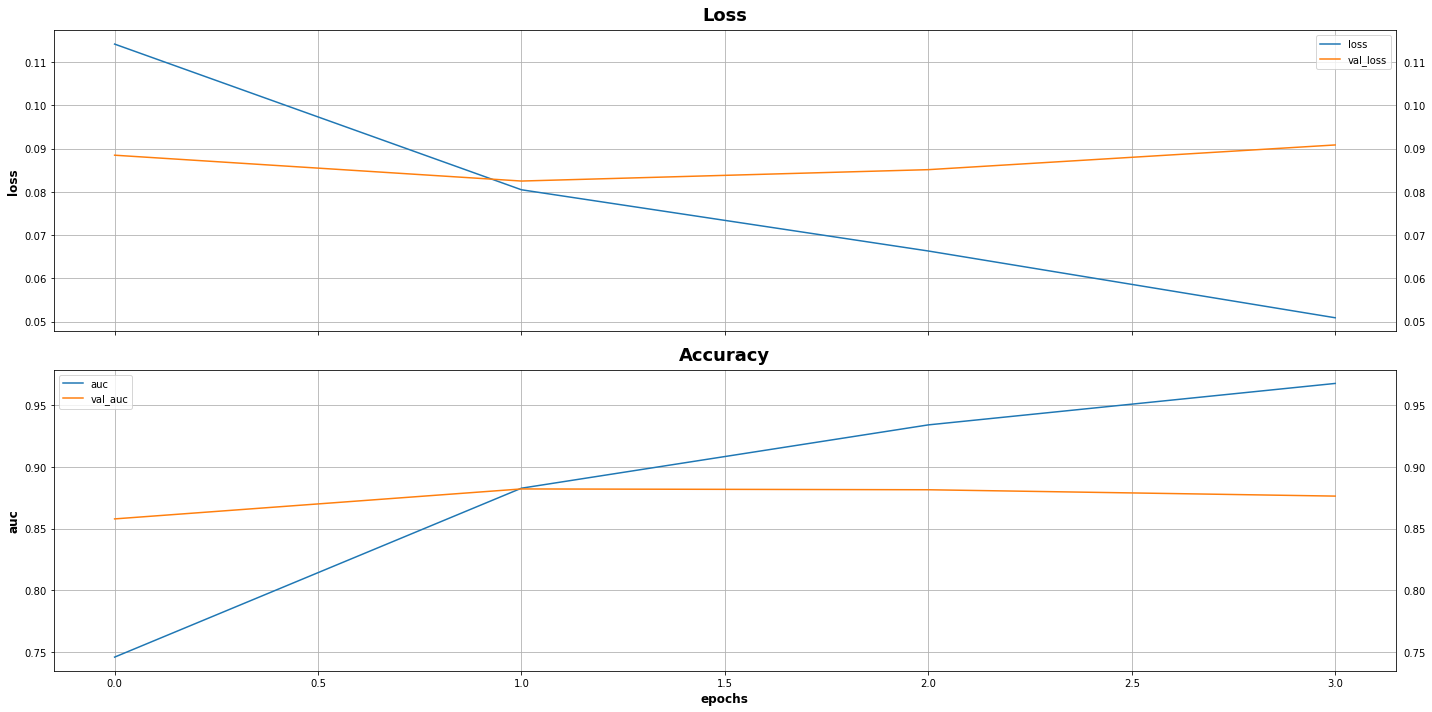

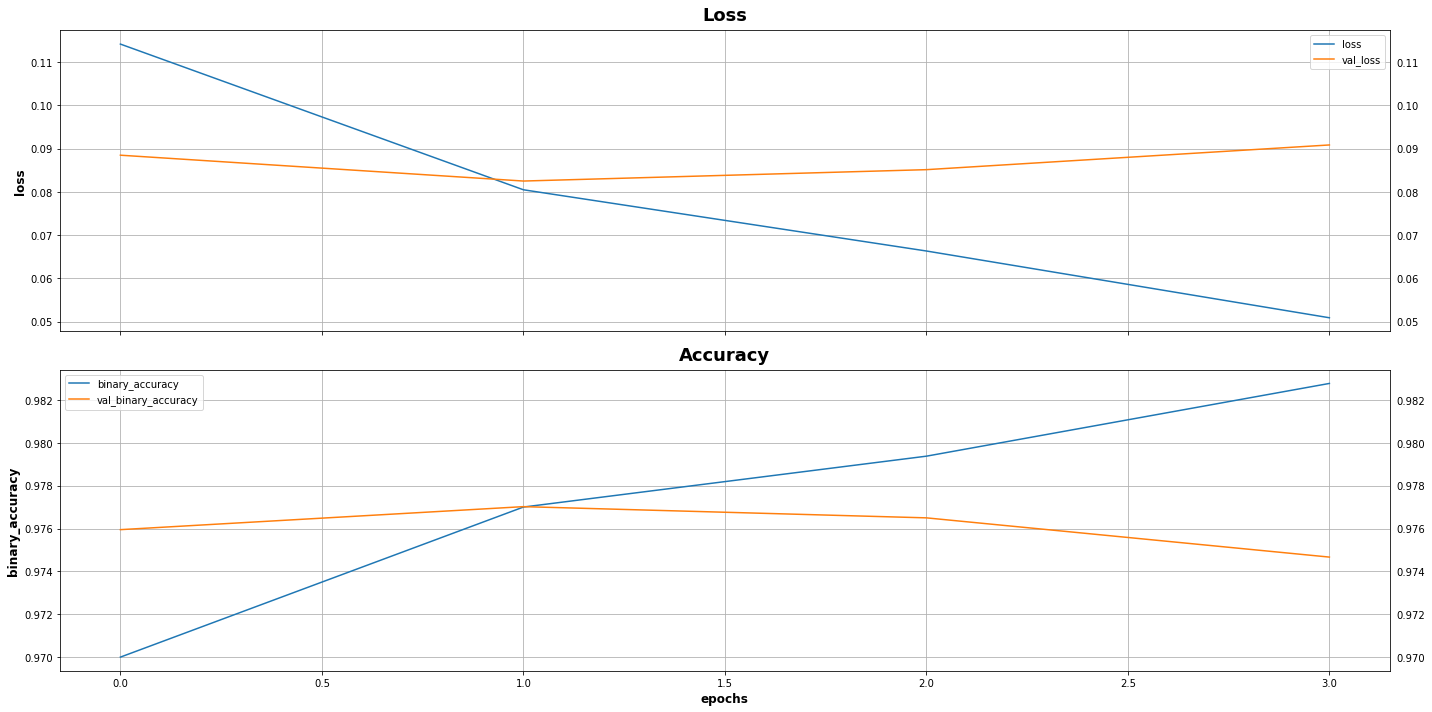

In [122]:
if config["bert_distil"]:

    history_bert = pd.DataFrame(data=history.history)
    for metric in ["auc", "binary_accuracy"]:
        visualize_history(history_bert, metrics=metric)

***
### 8.5.1 History

<img src="records/bert_base_results_auc.png" style="background-color:white">

<img src="records/bert_base_results_binaccuracy.png" style="background-color:white">

***
# 8 Conclusion